## $$ \begin{cases} y' = 1 + y^2, & t \in (0,2) \\ y(0) = 0 \\ y(t) = tan(t) \end{cases} $$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
def dy_dt(t, y):
    return 1 + y **2


def analytical(t, **kwargs):
    return np.tan(t)


In [10]:
def get_convergence_order(e1,  e2, n2, n1):
    return np.log(e1/e2) / np.log(n2/n1)


def approximate_with_method(method, h, t0, tf, y0):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros_like(t_values)
    y_values[0] = y0
    for j in range(len(t_values) - 1):
        dy = dy_dt(t_values[j], y_values[j])
        y_values[j + 1] = method(yj=y_values[j], h=h, dy=dy, t=t_values[j], dy_dt=dy_dt)
    return t_values, y_values


def plot_approximation_results(method, method_name, n_values, t0, tf, y0, table):
    t_values_analytical = np.linspace(t0, tf, 256)
    y_analytical = [analytical(t) for t in t_values_analytical]

    for i, n in enumerate(n_values):
        h = (tf - t0) / n

        t_values, y_aprox = approximate_with_method(method, h, t0, tf, y0)

        y_exact = y_analytical[-1]
        error = abs(y_aprox[-1] - y_exact)

        table["y_aprox"].append(y_aprox[-1])
        table["y_exact"].append(y_exact)
        table["error"].append(error)
        table["N"].append(n)
        table["h"].append(h)

        if i > 0:
            previous_error = table["error"][i - 1]
            previous_n = table["N"][i -  1]
            convergence_order = get_convergence_order(previous_error, error, n, previous_n)
            table["convergence_rate"].append(convergence_order)

        plt.plot(
            t_values,
            y_aprox,
            label=f"h = {h}",
            marker="^",
            linestyle="",
            markersize="4",
            color="r"
        )

        plt.plot(
            t_values_analytical,
            y_analytical,
        )
        plt.title(f"Approximation for step size {h} using {method_name}", fontsize="15")
        plt.xlabel("time (t)")
        plt.ylabel("y(t)")
        plt.grid()
        plt.show()

    table["convergence_rate"].append(np.nan)
    print(pd.DataFrame(table))


In [11]:
# given values, re used for all methods
number_of_subintervals = [8, 16, 32, 64, 128, 256]
# in this problem the h step is calculated based of the number of sub_intervals
t0 = 0
tf = 1
y0 = 0

def get_new_table():
    return {
        "N": [],
        "h": [],
        "y_aprox": [],
        "y_exact": [],
        "error": [],
        "convergence_rate": [],
    }


## Taylor Expansion (Order 4)

### $ y_{n+1} = y_n + h \cdot y'_n + \frac{h^2}{2} \cdot y''_n + \frac{h^3}{6} \cdot y'''_n + \frac{h^4}{24} \cdot y''''_n $

where

### $ y'_n = 1 + y_n^2, \quad $
### $ y''_n = 2y_n \cdot y'_n, \quad $
### $ y'''_n = 2y_n \cdot y''_n + 2(y'_n)^2, \quad $
### $ y''''_n = 2y_n \cdot y'''_n + 6y'_n \cdot y''_n. $


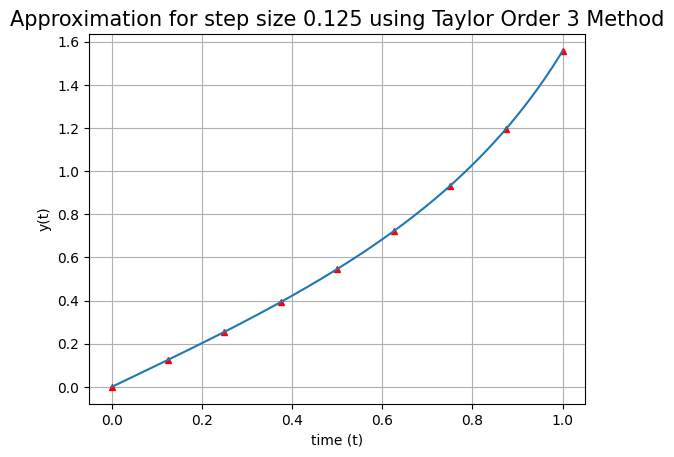

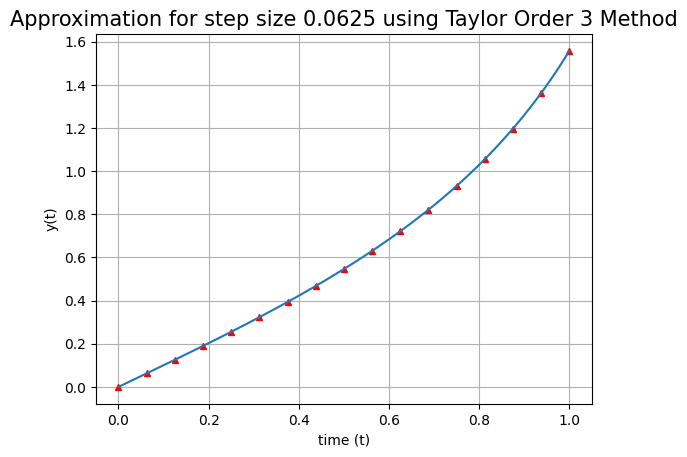

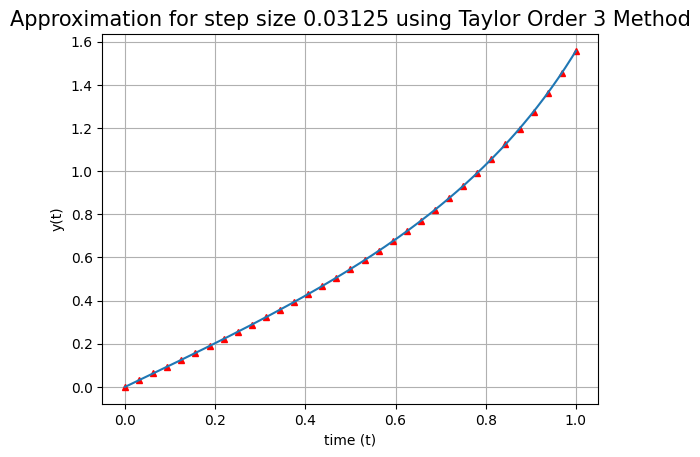

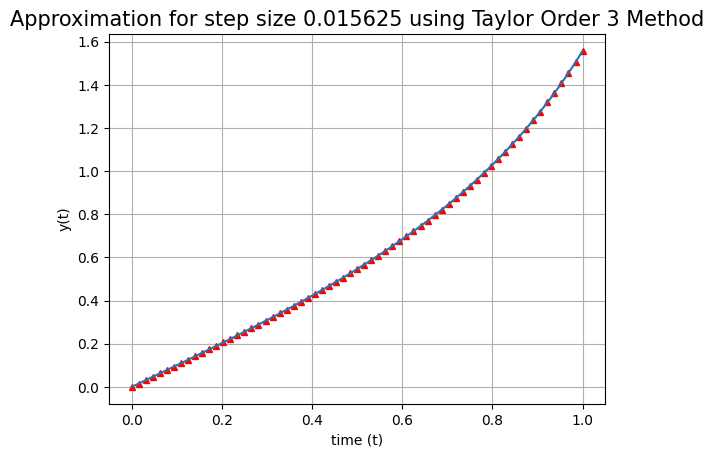

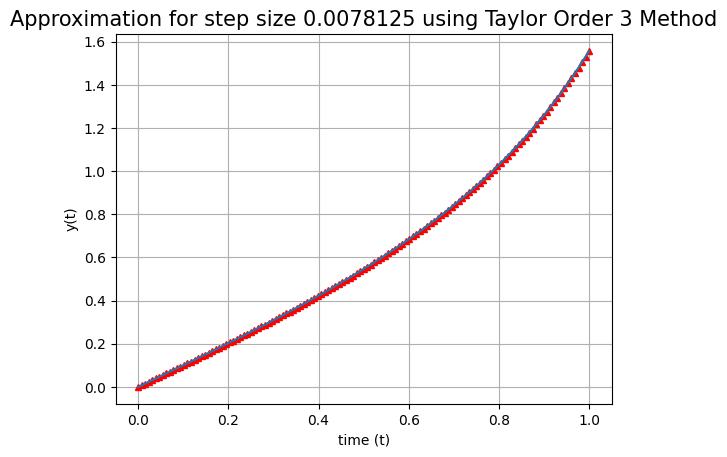

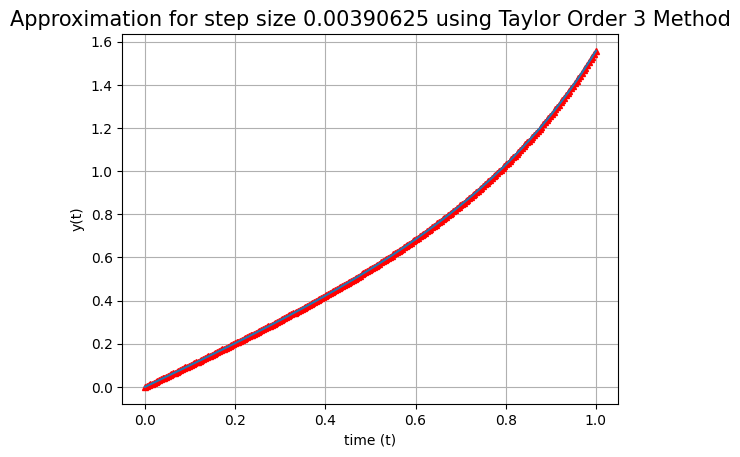

     N         h   y_aprox   y_exact         error  convergence_rate
0    8  0.125000  1.556688  1.557408  7.193179e-04          3.653161
1   16  0.062500  1.557351  1.557408  5.717549e-05          3.825686
2   32  0.031250  1.557404  1.557408  4.032401e-06          3.912932
3   64  0.015625  1.557407  1.557408  2.677033e-07          3.956534
4  128  0.007812  1.557408  1.557408  1.724323e-08          3.978289
5  256  0.003906  1.557408  1.557408  1.094042e-09               NaN


In [ ]:
def dy2_dt(t, y):
    return 2 * y * dy_dt(t, y)

def dy3_dt(t, y):
    return 2 * y * dy2_dt(t, y) + 2 * (dy_dt(t, y))**2

def dy4_dt(t, y):
    return 2 * y * dy3_dt(t, y) + 6 * dy_dt(t, y) * dy2_dt(t, y)

def taylor_4(yj, h, t, **kwargs):
    return (yj 
            + h * dy_dt(t, yj) 
            + (h**2) / 2 * dy2_dt(t, yj) 
            + (h**3) / 6 * dy3_dt(t, yj) 
            + (h**4) / 24 * dy4_dt(t, yj))


plot_approximation_results(
    method=taylor_4,
    method_name="Taylor Order 4 Method",
    n_values=number_of_subintervals,
    t0=t0,
    tf=tf,
    y0=y0,
    table=get_new_table(),
)


## Dormand–Prince 4th/5th Order (DP45)

### Adaptive Step-Size Method

Dormand–Prince (often referred to as “RK45”) is an embedded Runge–Kutta method that computes two different-order approximations (4th order and 5th order) in a single step. The difference between these two approximations provides an estimate of the local truncation error, enabling an automatic adjustment of the step size \(h\).

### Formulas

#### Intermediate Stages

Let $f(t, y)$ be the right-hand side of the ODE $ y' = f(t, y) $. Given $(t_n, y_n)$ and a step size $( h )$, the method calculates:

$$
\begin{aligned}
k_1 &= f\bigl(t_n,\, y_n\bigr), \\
k_2 &= f\!\Bigl(t_n + \tfrac{1}{5}h,\;\; y_n + h\,\tfrac{1}{5}k_1\Bigr), \\
k_3 &= f\!\Bigl(t_n + \tfrac{3}{10}h,\; y_n + h\,\bigl(\tfrac{3}{40}k_1 + \tfrac{9}{40}k_2\bigr)\Bigr), \\
k_4 &= f\!\Bigl(t_n + \tfrac{4}{5}h,\;\; y_n + h\,\bigl(\tfrac{44}{45}k_1 - \tfrac{56}{15}k_2 + \tfrac{32}{9}k_3\bigr)\Bigr), \\
k_5 &= f\!\Bigl(t_n + \tfrac{8}{9}h,\; y_n + h\,\bigl(\tfrac{19372}{6561}k_1 - \tfrac{25360}{2187}k_2 + \tfrac{64448}{6561}k_3 \\
   &\quad\;\; - \tfrac{212}{729}k_4\bigr)\Bigr), \\
k_6 &= f\!\Bigl(t_n + h,\;\;\;\; y_n + h\,\bigl(\tfrac{9017}{3168}k_1 - \tfrac{355}{33}k_2 + \tfrac{46732}{5247}k_3 \\
   &\quad\;\; + \tfrac{49}{176}k_4 - \tfrac{5103}{18656}k_5\bigr)\Bigr), \\
k_7 &= f\!\Bigl(t_n + h,\;\;\;\; y_n + h\,\bigl(\tfrac{35}{384}k_1 + 0\,k_2 + \tfrac{500}{1113}k_3 + \tfrac{125}{192}k_4 \\
   &\quad\;\; - \tfrac{2187}{6784}k_5 + \tfrac{11}{84}k_6\bigr)\Bigr).
\end{aligned}
$$

#### 5th-Order Approximation

$$
y_{n+1}^5 \;=\; 
y_n \;+\; h \Bigl(\,
\tfrac{35}{384}k_1 
\;+\; 0\,k_2 
\;+\; \tfrac{500}{1113}k_3 
\;+\; \tfrac{125}{192}k_4 
\;-\; \tfrac{2187}{6784}k_5 
\;+\; \tfrac{11}{84}k_6
\Bigr).
$$

#### 4th-Order Approximation (Embedded)

$$
y_{n+1}^4 \;=\;
y_n \;+\; h \Bigl(\,
\tfrac{5179}{57600}k_1 
\;+\; 0\,k_2 
\;+\; \tfrac{7571}{16695}k_3 
\;+\; \tfrac{393}{640}k_4 
\;-\; \tfrac{92097}{339200}k_5 
\;+\; \tfrac{187}{2100}k_6
\;+\;\tfrac{1}{40}k_7
\Bigr).
$$

#### Error Estimation

The local truncation error (per step) can be estimated by comparing the 5th-order and 4th-order approximations:

$$
\text{error} \;=\;
\bigl|\;y_{n+1}^5 \;-\; y_{n+1}^4\bigr|.
$$

#### Adaptive Step Size

1. **Compute** $ y_{n+1}^4,\,y_{n+1}^5$ and the local error estimate.
2. **Compare** this error with a user-specified tolerance \(\text{tol}\).
3. **Adjust** the step size $ h $ accordingly:
   - If $\text{error} < \text{tol}$, **accept** the step and possibly **increase** $h$.
   - If $\text{error} \ge \text{tol}$, **reject** the step and **decrease** $h$, then reattempt.

This process continues until the final time $t_f $ is reached, typically resulting in fewer steps in “easy” regions (where the solution is smooth) and more steps in “difficult” regions (where the solution changes rapidly).


In [13]:
def dormand_prince_45_adaptive_step(y, t, h, f):
    """
    Perform one adaptive Dormand–Prince (RK45) step *without* final acceptance logic.
    It returns (y4, y5) plus the local error estimate, so that the driver can decide
    whether to accept or reject the step.
    """
    # k1
    k1 = f(t, y)
    # k2
    k2 = f(t + 1 / 5 * h, y + h * (1 / 5 * k1))
    # k3
    k3 = f(t + 3 / 10 * h, y + h * (3 / 40 * k1 + 9 / 40 * k2))
    # k4
    k4 = f(t + 4 / 5 * h, y + h * (44 / 45 * k1 - 56 / 15 * k2 + 32 / 9 * k3))
    # k5
    k5 = f(
        t + 8 / 9 * h,
        y
        + h
        * (19372 / 6561 * k1 - 25360 / 2187 * k2 + 64448 / 6561 * k3 - 212 / 729 * k4),
    )
    # k6
    k6 = f(
        t + h,
        y
        + h
        * (
            9017 / 3168 * k1
            - 355 / 33 * k2
            + 46732 / 5247 * k3
            + 49 / 176 * k4
            - 5103 / 18656 * k5
        ),
    )
    # k7
    k7 = f(
        t + h,
        y
        + h
        * (
            35 / 384 * k1
            + 0 * k2
            + 500 / 1113 * k3
            + 125 / 192 * k4
            - 2187 / 6784 * k5
            + 11 / 84 * k6
        ),
    )

    # 5th order solution
    y5 = y + h * (
        35 / 384 * k1
        + 0 * k2
        + 500 / 1113 * k3
        + 125 / 192 * k4
        - 2187 / 6784 * k5
        + 11 / 84 * k6
    )

    # 4th order solution (Dormand–Prince's "embedded" lower-order part)
    y4 = y + h * (
        5179 / 57600 * k1
        + 0 * k2
        + 7571 / 16695 * k3
        + 393 / 640 * k4
        - 92097 / 339200 * k5
        + 187 / 2100 * k6
        + 1 / 40 * k7
    )

    # local error estimate ~ difference between the two solutions
    local_error = abs(y5 - y4)

    return y4, y5, local_error


def integrate_adaptive_dp45(f, t0, y0, tf, tol=1e-6, h_init=0.01):
    """
    Adaptive Dormand–Prince integrator from t0 to tf with local error tolerance 'tol'.
    """
    # Initialize
    t_values = [t0]
    y_values = [y0]

    t = t0
    y = y0
    h = h_init

    safety_factor = 0.9
    p = 5  # We'll treat the method as 5th-order for step scaling

    while t < tf:
        # If our step goes beyond tf, reduce it so we finish exactly at tf:
        if t + h > tf:
            h = tf - t

        # Do one DP45 step, get the 4th- and 5th-order estimates:
        y4, y5, local_err = dormand_prince_45_adaptive_step(y, t, h, f)

        # If local_err == 0, it means no difference => perfect or very stable region
        # to avoid dividing by zero in step-size update, set error to a tiny number
        if local_err == 0:
            local_err = 1e-16

        # Check if within tolerance
        if local_err < tol:
            # Accept the step
            t = t + h
            y = y5
            t_values.append(t)
            y_values.append(y)

            # Propose new step size (increase if we are well below tol)
            h_new = safety_factor * h * (tol / local_err) ** (1 / (p + 1))
            # Ensure h_new isn't *too* big or too small
            h = max(1e-10, min(h_new, 10 * h))  # for example
        else:
            # Reject the step, reduce h and retry
            h = safety_factor * h * (tol / local_err) ** (1 / (p + 1))
            # again, clamp
            h = max(1e-10, h)

        if h < 1e-14:
            print("ERROR: step size underflow")
            break

        # if we reached tf exactly, we can break
        if abs(t - tf) < 1e-15:
            break

    return np.array(t_values), np.array(y_values)


tol=0.001, steps=4, final error=2.527286e-05


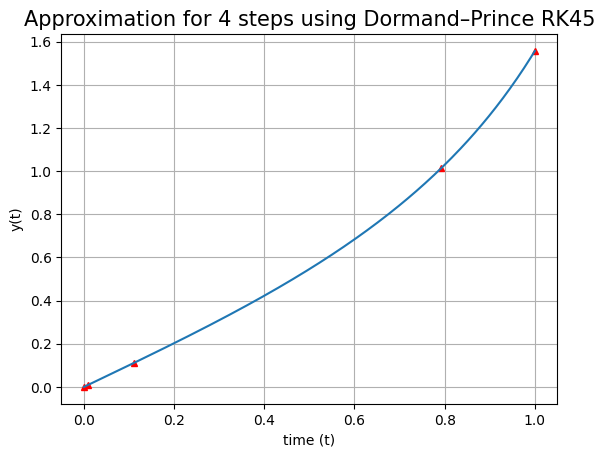

tol=0.0001, steps=5, final error=1.361870e-05


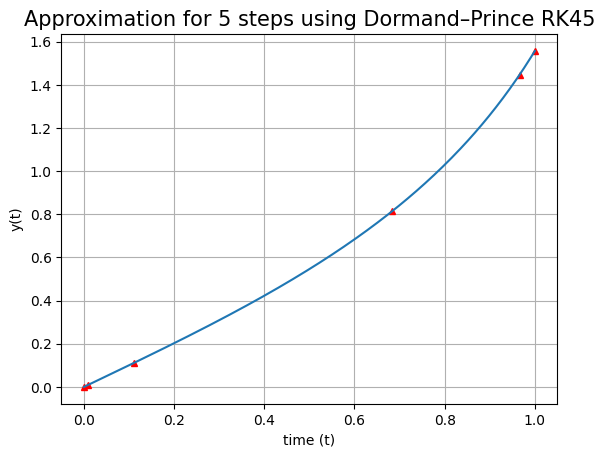

tol=1e-05, steps=6, final error=1.213442e-06


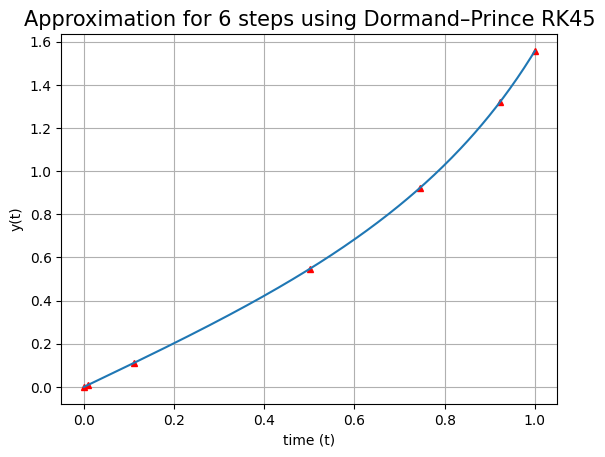

tol=1e-06, steps=8, final error=4.495307e-07


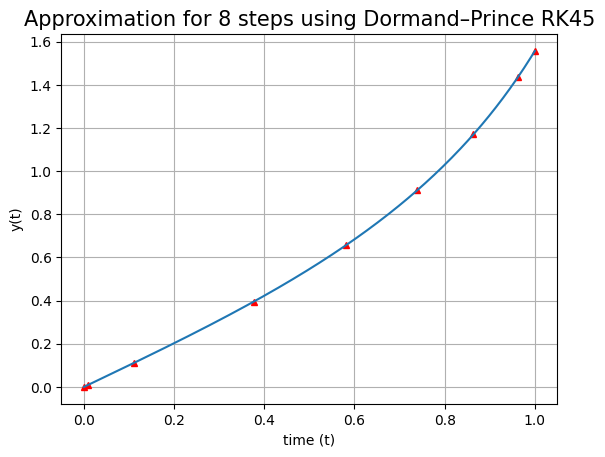

In [14]:
tol_list = [1e-3, 1e-4, 1e-5, 1e-6]

t_values_analytical = np.linspace(t0, tf, 256)
y_analytical = [analytical(t) for t in t_values_analytical]
for tol in tol_list:
    t_values, y_values = integrate_adaptive_dp45(f=dy_dt, t0=t0, y0=y0, tf=tf, tol=tol)
    # final approximate
    y_approx_final = y_values[-1]
    # exact at tf
    y_exact_final = y_analytical[-1]
    # error
    err = abs(y_approx_final - y_exact_final)
    print(f"tol={tol}, steps={len(t_values) - 1}, final error={err:e}")
    plt.plot(
        t_values,
        y_values,
        marker="^",
        linestyle="",
        markersize="4",
        color="r",
    )

    plt.plot(
        t_values_analytical,
        y_analytical,
    )
    plt.title(
        f"Approximation for {len(t_values) - 1} steps using Dormand–Prince RK45",
        fontsize="15",
    )
    plt.xlabel("time (t)")
    plt.ylabel("y(t)")
    plt.grid()
    plt.show()


## Conclusiones

### ¿La visualización de las aproximaciones es similar a la solución real?

Sí, incluso para Taylor 4, desde $ N=8 $ las aproximaciones obtenidas están muy cerca a la solución real. En el caso de RK45 solo le llevó 4 pasos estar a $0.001$ de la solución real.

### ¿Las gráficas aproximadas se acercan a la exacta cuando cambio h o cuando cambio método?

Cuando se cambia $ h $ (es decir, establece un $ N $ mayor) el Taylor 4 se acerca más y más a la solución exacta, como es de esperarse. En el caso de RK45, se cambia la tolerancia, y al hacerlo se puede apreciar como el método por si solo haya el $h$ óptimo hasta conseguir estar dentro de la tolerancia específicada

### ¿Se evidencia el orden del método?

En RK45, al ser un método adaptativo y no tener control sobre el $ h $, no se fue posible establecer el método. En el caso de Taylor 4, la tabla muestra claramente como el orden de convergencia se acerca a 4.